# **📈📉Google Finance Forecasting Using Simple Machine Learning Algorithms.** 
- **By:** Jorge Félix Martínez Pazos
- **From:** Universidad de Ciencias Informaticas

## Imports

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras .metrics import mean_absolute_error
import yfinance as yf
from pandas.plotting import scatter_matrix

### Loading Data From Yahoo finance

In [2]:
data = yf.download("GOOGL")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044
...,...,...,...,...,...,...
2023-05-22,122.940002,126.430000,122.739998,125.050003,125.050003,35253000
2023-05-23,124.160004,124.629997,122.209999,122.559998,122.559998,34046300
2023-05-24,121.120003,121.910004,119.860001,120.900002,120.900002,34182600


### Plot Data to Gain Insigths

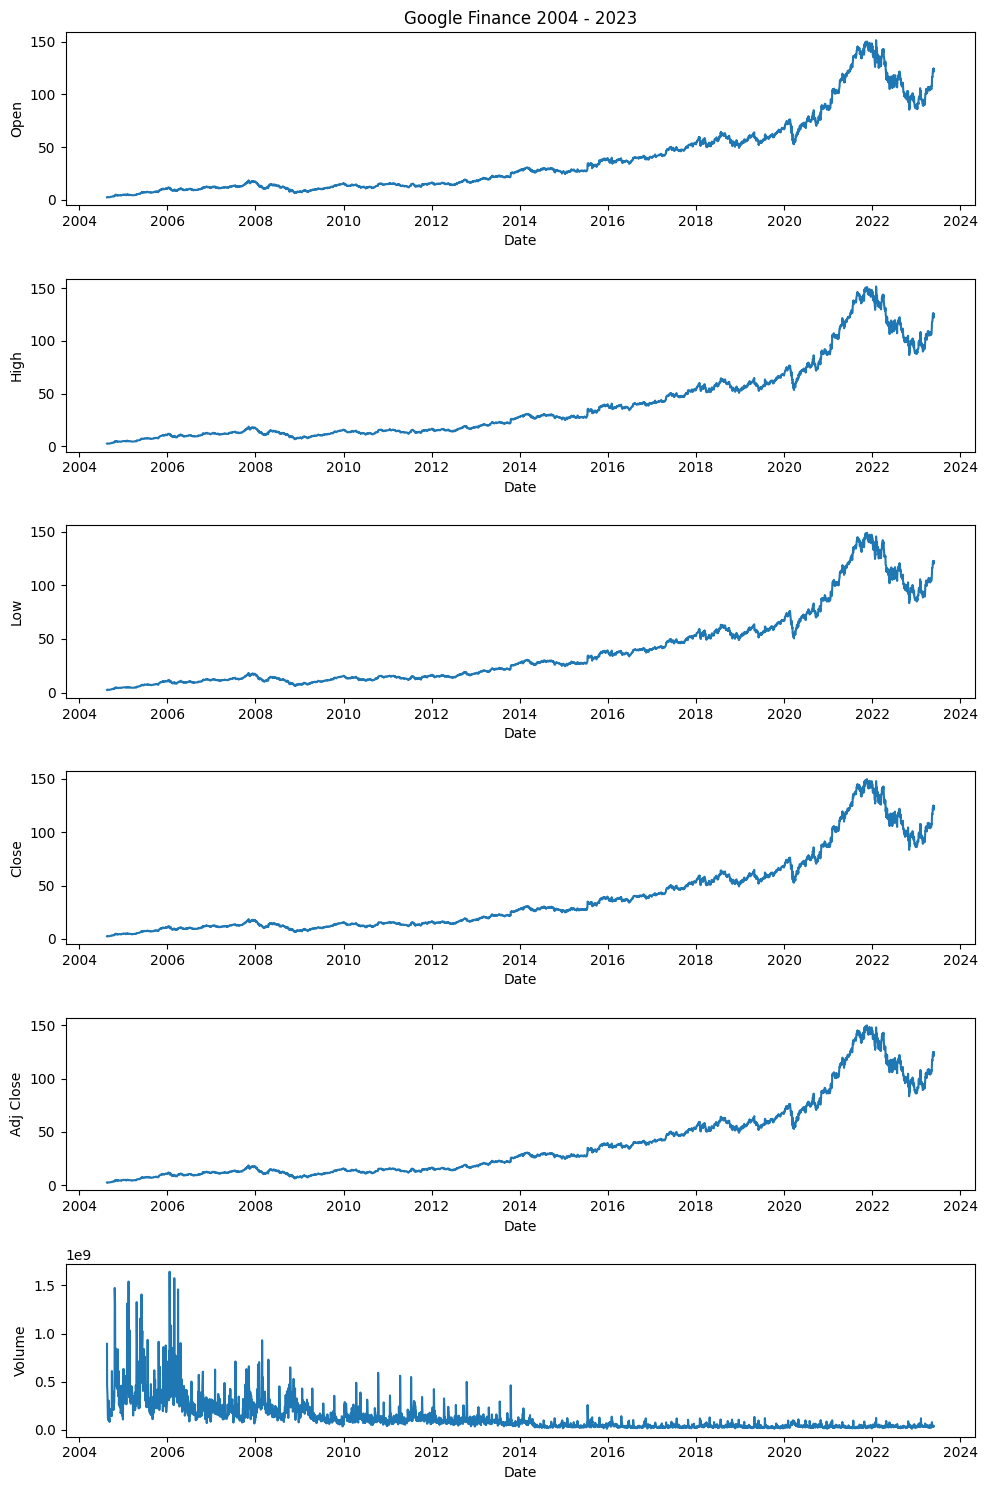

In [16]:
def plot_columns(df):
    num_cols = len(df.columns)
    fig, axes = plt.subplots(num_cols, figsize=(10, 2.5*num_cols))
    for i, column in enumerate(df.columns):
        sns.lineplot(ax=axes[i], data=df, x=df.index, y=column)
        axes[0].set_title('Google Finance 2004 - 2023')
    plt.tight_layout()
    plt.show()

plot_columns(data)

Text(0.5, 1.0, 'Google Open Fincance Time Series')

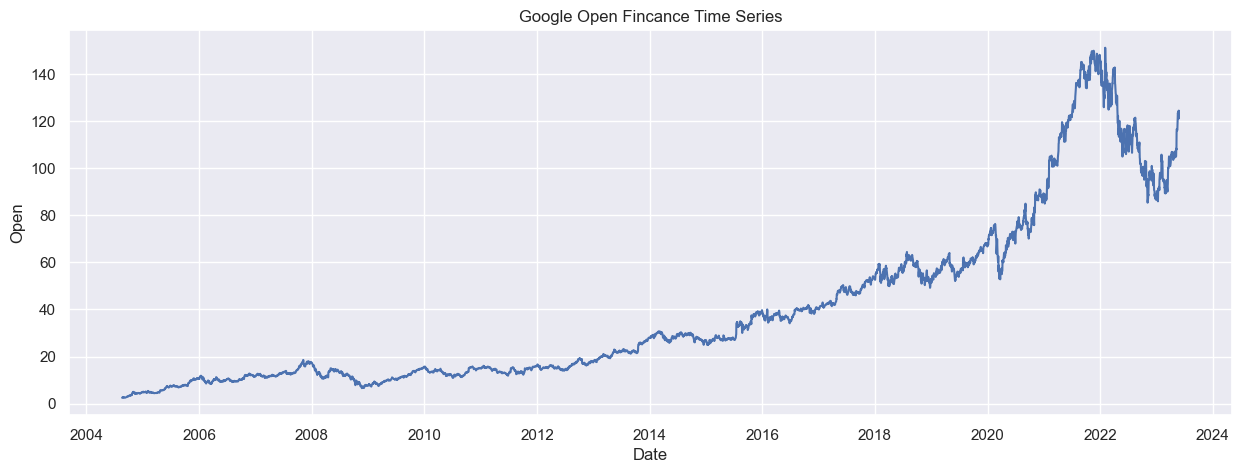

In [88]:
plt.figure(figsize=(15,5))
sns.lineplot(data['Open'])
plt.title('Google Open Fincance Time Series')

## Data Pre Processing

#### Split Train Test Data With a Split Time of **2020-01-01**

In [31]:
split_time = '2020-01-01'
train_data = data.loc[:split_time]
test_data = data.loc[split_time:]

In [33]:
train_open_data = train_data['Open']
valid_open_data = test_data['Open']

# Show Series
print(f'Train Open Data \n{train_open_data.head()}\n')
print(f'Validation Open Data \n{valid_open_data.head()}\n')

Train Open Data 
Date
2004-08-19    2.502503
2004-08-20    2.527778
2004-08-23    2.771522
2004-08-24    2.783784
2004-08-25    2.626627
Name: Open, dtype: float64

Validation Open Data 
Date
2020-01-02    67.420502
2020-01-03    67.400002
2020-01-06    67.581497
2020-01-07    70.023003
2020-01-08    69.740997
Name: Open, dtype: float64



## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [34]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

### Very Simple Neural Network

In [38]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(train_open_data, window_size)
valid_set = window_dataset(valid_open_data, window_size)

# Model Buidling
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)

# Model Compiling
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Model Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))

# Model Fitting
history = model.fit(train_set, epochs=200,
          validation_data=valid_set,
          callbacks=[early_stopping,lr_schedule])

Epoch 1/200


d:\Software Development\PythonLearning\Curso-Python\Virtual Enviroment\deeplearning\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


120/120 [==============================] - 1s 6ms/step - loss: 24.5623 - mae: 25.0623 - val_loss: 61.8766 - val_mae: 62.3766 - lr: 1.0000e-06
Epoch 2/200
120/120 [==============================] - 1s 5ms/step - loss: 3.9659 - mae: 4.4459 - val_loss: 5.1428 - val_mae: 5.6238 - lr: 1.0798e-06
Epoch 3/200
120/120 [==============================] - 1s 5ms/step - loss: 0.6722 - mae: 1.0569 - val_loss: 5.1102 - val_mae: 5.5906 - lr: 1.1659e-06
Epoch 4/200
120/120 [==============================] - 1s 5ms/step - loss: 0.6660 - mae: 1.0501 - val_loss: 5.0883 - val_mae: 5.5709 - lr: 1.2589e-06
Epoch 5/200
120/120 [==============================] - 1s 5ms/step - loss: 0.6627 - mae: 1.0456 - val_loss: 5.0457 - val_mae: 5.5269 - lr: 1.3594e-06
Epoch 6/200
120/120 [==============================] - 1s 6ms/step - loss: 0.6538 - mae: 1.0363 - val_loss: 5.0050 - val_mae: 5.4850 - lr: 1.4678e-06
Epoch 7/200
120/120 [==============================] - 1s 5ms/step - loss: 0.6492 - mae: 1.0295 - val_loss: 

#### History Insights
- Model Metrics Behaivor

59


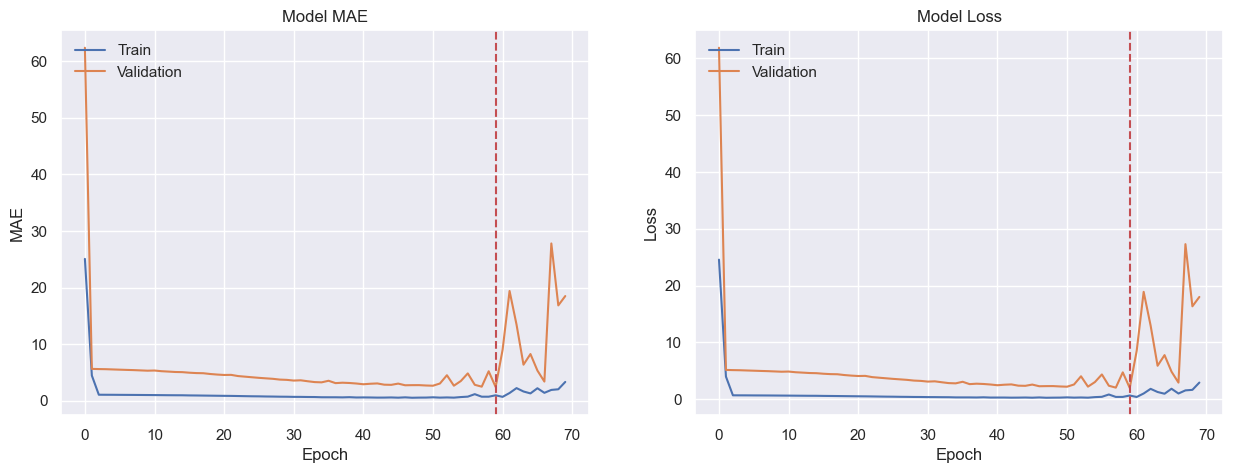

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_history(history):
    sns.set()
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    axs[0].plot(history.history['mae']) 
    axs[0].plot(history.history['val_mae']) 
    axs[0].set_title('Model MAE')
    axs[0].set_ylabel('MAE') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')
    
    best_epoch = np.argmin(history.history['val_mae'])
    axs[0].axvline(x=best_epoch, color='r', linestyle='--')
    
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')
    
    best_epoch = np.argmin(history.history['val_loss'])
    print(best_epoch)
    axs[1].axvline(x=best_epoch, color='r', linestyle='--')
    
    plt.show()

plot_history(history)


- The Best Epoch is 59 it is Auto Restored Via Early Stopping Callback

In [43]:
# Forecast Function
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [50]:
# Forecasting
forecast = model_forecast(model, valid_open_data, window_size)[:, 0]
forecast

26/26 [==============================] - 0s 6ms/step


array([ 74.74596 ,  75.14674 ,  75.95994 ,  76.13377 ,  77.7072  ,
        76.32462 ,  73.660065,  72.018974,  70.79517 ,  69.957565,
        68.935776,  66.50266 ,  68.84709 ,  66.66947 ,  69.04939 ,
        68.02407 ,  63.200294,  62.819096,  65.19501 ,  60.122566,
        59.039394,  56.27597 ,  51.883778,  57.42961 ,  55.709732,
        55.755184,  54.12188 ,  52.15774 ,  55.189945,  54.074467,
        56.664032,  57.87004 ,  55.876347,  60.297924,  56.131824,
        54.33509 ,  55.540234,  56.54051 ,  63.331524,  58.36894 ,
        60.686924,  60.6072  ,  59.660347,  67.09148 ,  64.585785,
        62.663643,  63.81378 ,  62.292015,  63.876213,  63.401558,
        65.73478 ,  64.89987 ,  63.11443 ,  66.16699 ,  66.358475,
        66.162285,  66.53305 ,  68.236015,  68.77807 ,  68.02903 ,
        67.77487 ,  68.00398 ,  70.07501 ,  70.42609 ,  68.52493 ,
        67.56139 ,  66.855965,  68.50403 ,  69.34152 ,  69.56339 ,
        71.0231  ,  72.84514 ,  71.4537  ,  72.50183 ,  70.686

In [66]:
# Forecast DataFrame
forecast_df = pd.DataFrame(forecast[:-1], 
                           index=valid_open_data.index[window_size:window_size+len(forecast)],
                            columns=['Forecast'])

In [59]:
# Forecast Series
forecast_series = forecast_df['Forecast'].squeeze()
forecast_series

Date
2020-02-14     74.745956
2020-02-18     75.146744
2020-02-19     75.959938
2020-02-20     76.133774
2020-02-21     77.707199
                 ...    
2023-05-22    122.747910
2023-05-23    124.018600
2023-05-24    121.492905
2023-05-25    123.641129
2023-05-26    120.144981
Name: Forecast, Length: 827, dtype: float32

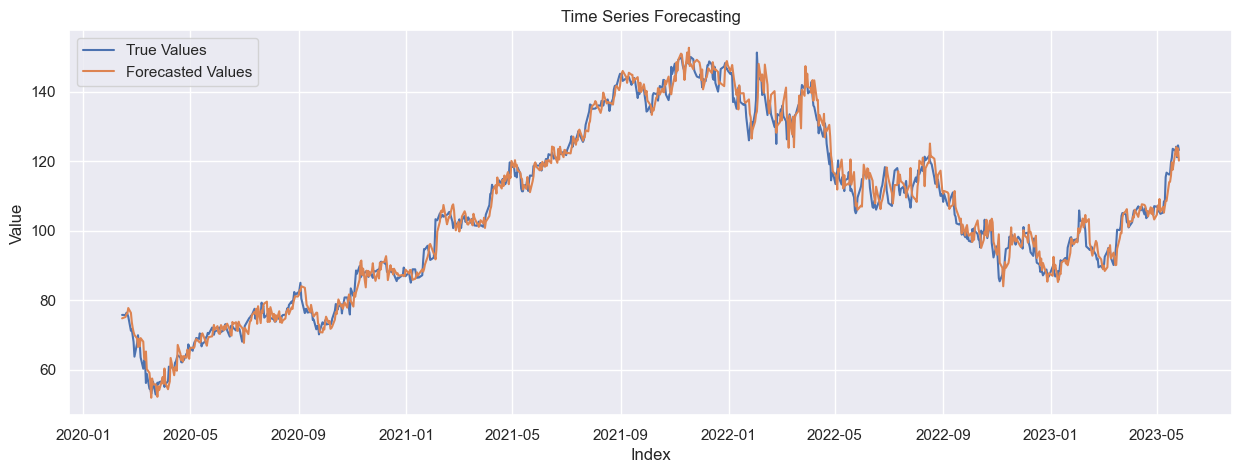

In [83]:
# Ploting Real Values vs Forecasted Values
def plot_predictions(y_true, y_pred):
    sns.set()
    plt.figure(figsize=(15,5))
    plt.plot(y_true, label='True Values')
    plt.plot(y_pred, label='Forecasted Values')
    plt.title('Time Series Forecasting')
    plt.ylabel('Value')
    plt.xlabel('Index')
    plt.legend(loc='upper left')
    plt.show()

plot_predictions(valid_open_data, forecast_series)

In [78]:
print(valid_open_data.head(5),'\n')
print(forecast_series.head(5))

Date
2020-02-14    75.726501
2020-02-18    75.717003
2020-02-19    76.360001
2020-02-20    75.950500
2020-02-21    75.228996
Name: Open, dtype: float64 

Date
2020-02-14    74.745956
2020-02-18    75.146744
2020-02-19    75.959938
2020-02-20    76.133774
2020-02-21    77.707199
Name: Forecast, dtype: float32


In [73]:
print('Valid Data:',len(valid_open_data))
print('Forecasted Data:',len(forecast_series))

Valid Data: 857
Forecasted Data: 827


- As can be observed, there is a difference of 30 between the lengths of the validation set and the forecasted values. This is due to the window size used during the forecasting process.
    - To align the indices of the validation set and the forecasted values, we replaced the validation data starting from the window size.

In [74]:
valid_open_data = valid_open_data[window_size: ]
print('Valid Data:',len(valid_open_data))
print('Forecasted Data:',len(forecast_series))

Valid Data: 827
Forecasted Data: 827


In [79]:
print(valid_open_data.head(5),'\n')
print(forecast_series.head(5))

Date
2020-02-14    75.726501
2020-02-18    75.717003
2020-02-19    76.360001
2020-02-20    75.950500
2020-02-21    75.228996
Name: Open, dtype: float64 

Date
2020-02-14    74.745956
2020-02-18    75.146744
2020-02-19    75.959938
2020-02-20    76.133774
2020-02-21    77.707199
Name: Forecast, dtype: float32


In [82]:
print(f'Mean Absolute Error: {mean_absolute_error(valid_open_data, forecast_series).numpy()}')

Mean Absolute Error: 2.424084424972534


### Conclusions
- Very Good Results are Achieved for This Particular Task ***(MAE = 2.42)***
- The Simple Neural Network Works Rigth for Simple Time Series Forecasting Tasks
- For More Dificult Task Another Arquitectures Should Be Applied Suchs as:
    - RNN
    - LSTM
    - GRU
    - CNN
- ##### **WaveNet Engine Is a Very Powerfull Arquitecture Based on ConvNets Developed by DeepMind**

# **🔎Anomaly Detection in Google Finance** 

In [89]:
# ADTK Imports
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import *

### Outliers Detection using Boxplot
- Volumen Will be Delete Since is Outside the Common Value Range

<AxesSubplot:>

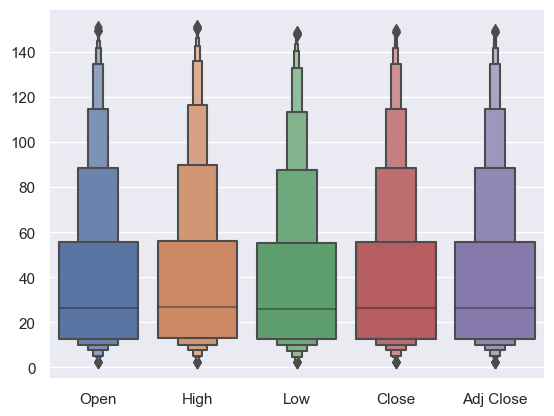

In [91]:
del data['Volume']
sns.boxenplot(data)

- Minimun Outliers Detected

In [92]:
open_data = data['Open']
open_data

Date
2004-08-19      2.502503
2004-08-20      2.527778
2004-08-23      2.771522
2004-08-24      2.783784
2004-08-25      2.626627
                 ...    
2023-05-22    122.940002
2023-05-23    124.160004
2023-05-24    121.120003
2023-05-25    124.519997
2023-05-26    123.169998
Name: Open, Length: 4726, dtype: float64

In [94]:
open_data.describe()

count    4726.000000
mean       39.118569
std        35.839776
min         2.482232
25%        12.757445
50%        26.292001
75%        55.639001
max       151.250000
Name: Open, dtype: float64

### **Threshold Detector**
- Detector that detects anomaly based on user-given threshold.

- This detector compares time series values with user-given thresholds, and identifies time points as anomalous when values are beyond the thresholds.

Text(0.5, 1.0, 'Threshold Anomaly Detection')

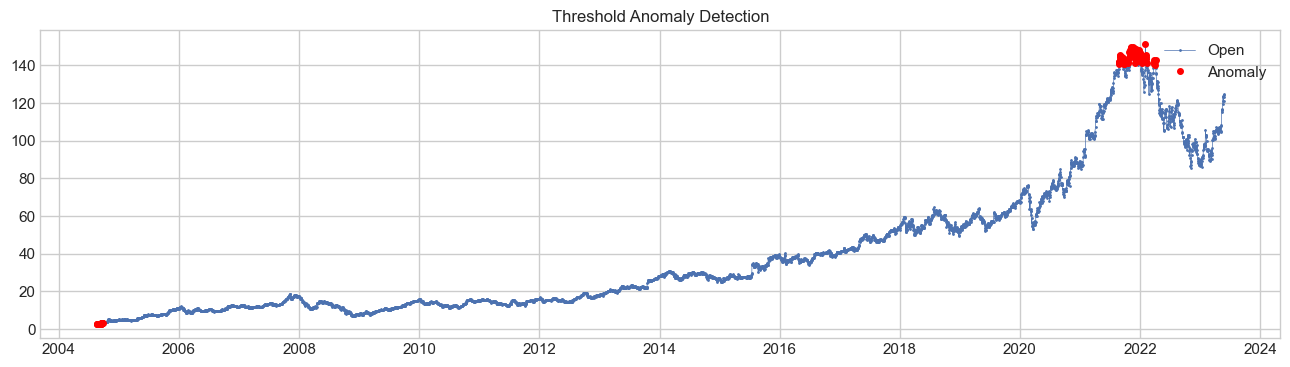

In [118]:
Threshold_detector = ThresholdAD(low=3, high=140)
anomalies = Threshold_detector.detect(open_data)
plot(open_data,anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")
plt.title("Threshold Anomaly Detection")

### **Quantile Detector**
- Detector that detects anomaly based on quantiles of historical data.

- This detector compares time series values with user-specified quantiles of historical data, and identifies time points as anomalous when values are beyond the thresholds.

Text(0.5, 1.0, 'Quantile Anomaly Detection')

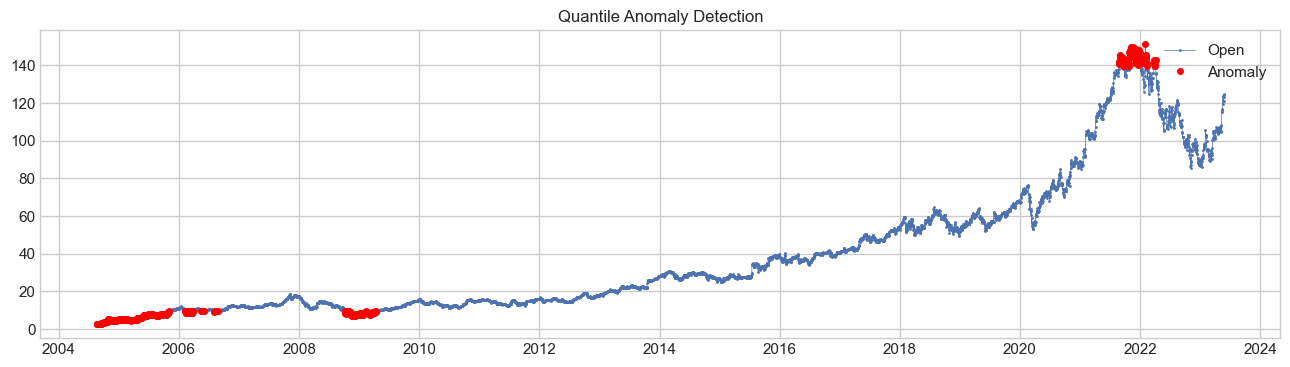

In [117]:
quantile_detector = QuantileAD(low=0.1, high=0.98)
anomalies = quantile_detector.fit_detect(open_data)
plot(open_data,anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")
plt.title("Quantile Anomaly Detection")

### **Inter Quartile Detector**
- Detector that detects anomaly based on inter-quartile range of historical data.

- This detector compares time series values with 1st and 3rd quartiles of historical data, and identifies time points as anomalous when differences are beyond the inter-quartile range (IQR) times a user-given factor c.

Text(0.5, 1.0, 'Inter Quantile Range Anomaly Detection')

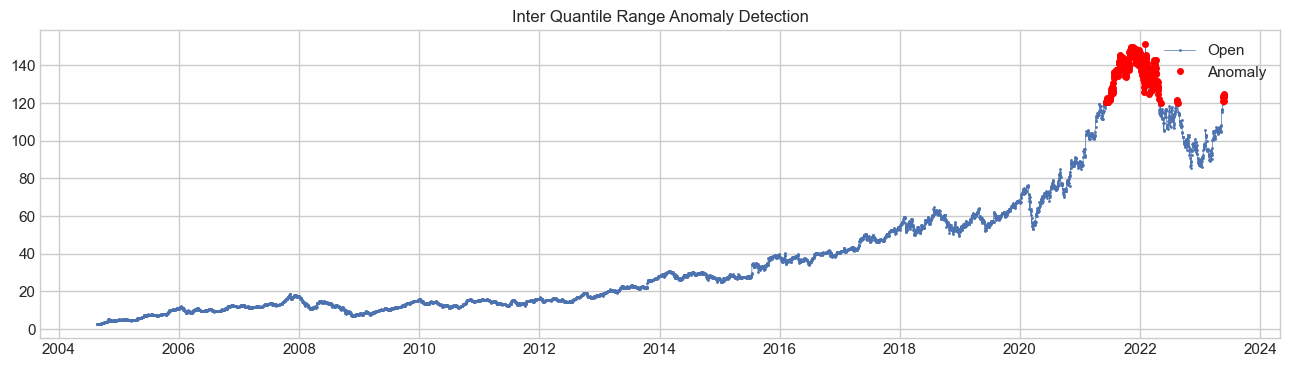

In [116]:
iqr_detector = InterQuartileRangeAD(c=1.5)
anomalies = iqr_detector.fit_detect(open_data)
plot(open_data,anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")
plt.title("Inter Quantile Range Anomaly Detection")

### **Persistant Detector**
- Detector that detects anomaly based on values in a preceding period.

- This detector compares time series values with the values of their preceding time windows, and identifies a time point as anomalous if the change of value from its preceding average or median is anomalously large.

In [105]:
persist_detector = PersistAD(c=15, side='positive')
anomalies = persist_detector.fit_detect(open_data)

Text(0.5, 1.0, 'Positive Persist Anomaly Detector')

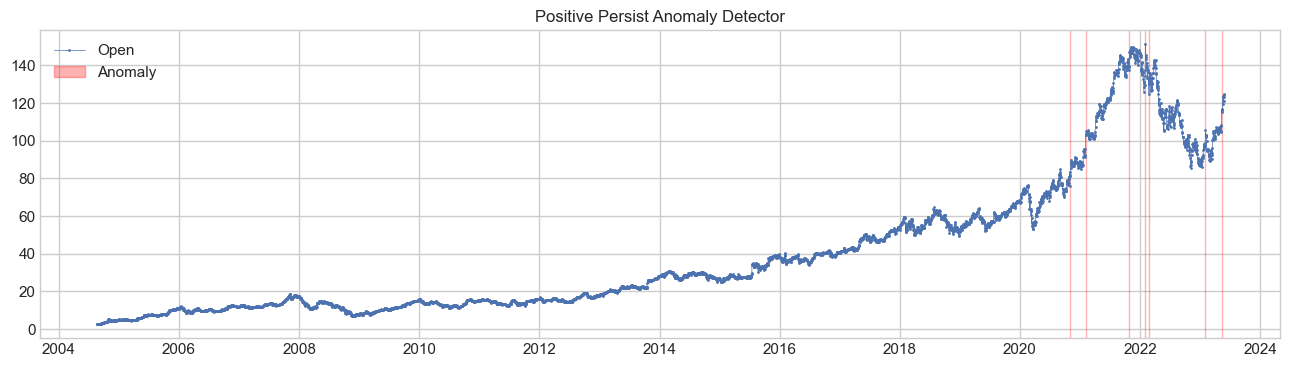

In [106]:
plot(open_data,anomaly=anomalies, anomaly_color='red')
plt.title('Positive Persist Anomaly Detector')

Text(0.5, 1.0, 'Positive Persist Anomaly Detector')

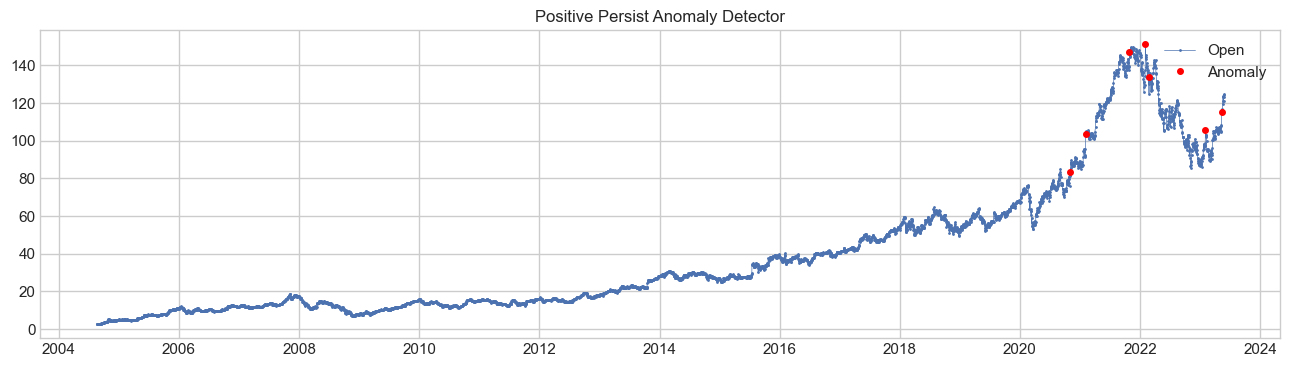

In [108]:
plot(open_data,anomaly=anomalies, anomaly_color='red',anomaly_tag='marker')
plt.title('Positive Persist Anomaly Detector')

In [109]:
persist_detector = PersistAD(c=15, side='negative')
anomalies = persist_detector.fit_detect(open_data)

Text(0.5, 1.0, 'Negative Persist Anomaly Detector')

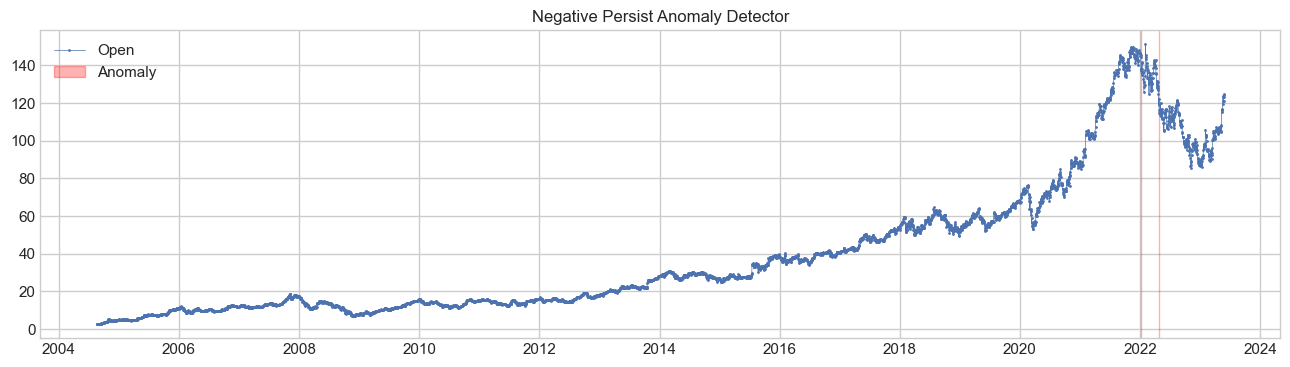

In [110]:
plot(open_data,anomaly=anomalies, anomaly_color='red')
plt.title('Negative Persist Anomaly Detector')

Text(0.5, 1.0, 'Negative Persist Anomaly Detector')

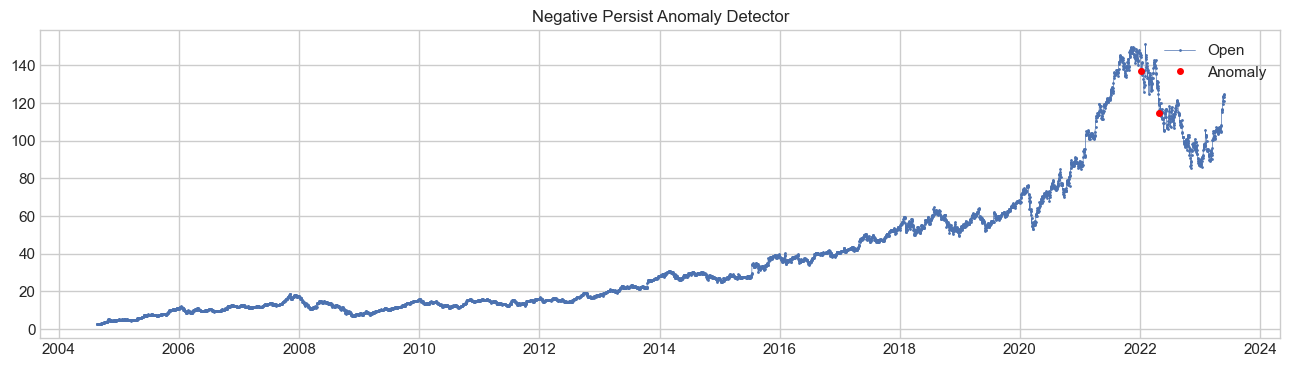

In [112]:
plot(open_data,anomaly=anomalies, anomaly_color='red',anomaly_tag='marker')
plt.title('Negative Persist Anomaly Detector')

### **Volatility Detector**
- Detector that detects shift of volatility in time series.

- This detector compares volatility of two time windows next to each others, and identifies the time point in between as a volatility-shift point if the difference of the volatility measurement in the two time windows is anomalously large.

Text(0.5, 1.0, 'Volatility Anomaly Detection')

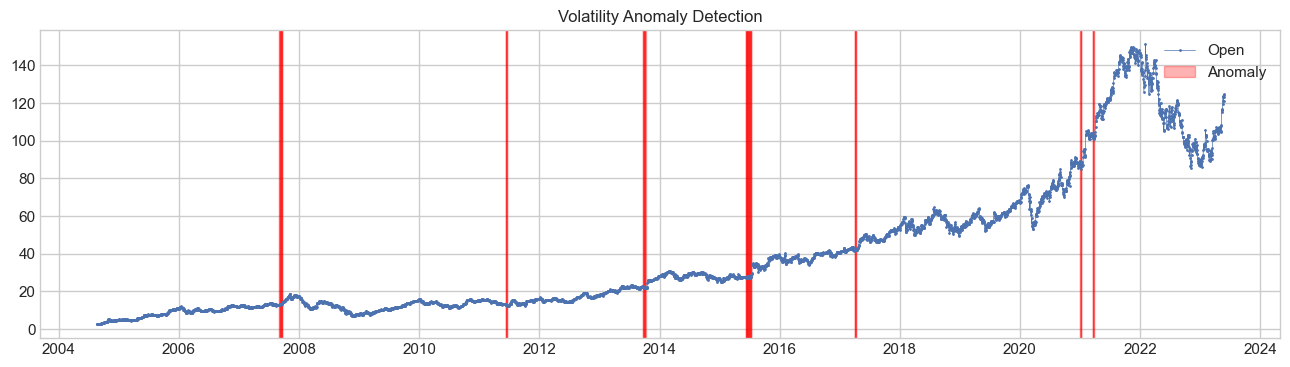

In [115]:
volatility_detector = VolatilityShiftAD(c=6.0, side='positive',window=30)
anomalies = volatility_detector.fit_detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='red')
plt.title('Volatility Anomaly Detection')